# NLP : importing a large number of tweets and predicting if the tweet is **Disaster** related or **Non-Disaster** related

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6e5b561e-e4a9-326d-59ac-a7cd8160d457)


## Get some helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback

--2024-01-26 16:45:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-26 16:45:27 (81.5 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



## Get the text data (Tweets) from Kaggle

In [3]:
# Download data
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-01-26 16:45:31--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.207, 173.194.206.207, 108.177.112.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.3’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2024-01-26 16:45:32 (33.0 MB/s) - ‘nlp_getting_started.zip.3’ saved [607343/607343]



## Visualize the text data

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [6]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target 1 (real disaster)
Text:
Investigators rule catastrophic structural failure resulted in 2014 ... http://t.co/QU1IUg3E9r

---

Target 0 (not real disaster)
Text:
Trouble with mental fog? Consider these tests: http://t.co/XAerMBMvlv

---

Target 0 (not real disaster)
Text:
#Vancouver to host 100s of electronic art events including @MUTEK_Montreal. http://t.co/vjBhxN9x1O #ISEA2015

---

Target 1 (real disaster)
Text:
#Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way

---

Target 0 (not real disaster)
Text:
@RaynbowAffair Editor In Chief @DiamondKesawn Releases Issue #7 http://t.co/RPnEAJ6fOD of #RAmag. #Fashion #Models and #Mayhem

---



## Split data into training and validation sets

* since our testing data doesnt have a label, We are going to split our training data into training and validating to get the accuracy


In [7]:
# No target for test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
from sklearn.model_selection import train_test_split
# Use train_test_split to split data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training datafor val split
                                                                            random_state=42)

In [9]:
# check the data
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

## Coverting text into numbers (tokenization and embedding)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 10000 # How many words in the vocabulary
max_length = 15 # how many words from a tweet our model will see
text_vectorzier = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [11]:
# Fit the text vectorizer to the train data
text_vectorzier.adapt(train_sentences)

## Creating an embedding using and embedding layer

The parameters we care most about for our embedding layer:
1. input_dim = the size of our vocabulary
2. Output_dim = the size of the output embedding vector
3. input_length = the length of the sequences being passed to the embedding layer

In [12]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, #set input shape
                             output_dim=128,
                             input_length=max_length,
                             )

In [13]:
# View the data after embedding
# Get a random sentence
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence}\n")

# Embed the random sentence
sample_embed = embedding(text_vectorzier([random_sentence]))
sample_embed

Original text: Violators of the new improved Reddit will be shot into the sun. Survivors will be hurled into a black hole and then nuked.



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04055393, -0.02122158,  0.03674633, ...,  0.01061935,
          0.04601378, -0.00161389],
        [ 0.01809876, -0.01704239, -0.04077797, ..., -0.025324  ,
         -0.02499108, -0.00851357],
        [ 0.04777262, -0.01138476,  0.00150478, ..., -0.0469213 ,
          0.00661049, -0.03327546],
        ...,
        [-0.00285863,  0.041694  , -0.01383524, ...,  0.03201238,
         -0.01884496,  0.03457322],
        [ 0.04064507, -0.01249465,  0.00112386, ..., -0.01149929,
         -0.02486222,  0.04265174],
        [-0.03168478, -0.02640988, -0.00573652, ...,  0.01854379,
         -0.01197337,  0.03945435]]], dtype=float32)>

## Build the model

* we are going to use a pretrained model from TensorFlow Hub (Universal-Sentence-Encoder)

In [14]:
import tensorflow_hub as hub
SAVE_DIR = "model_logs"
# Create a keras layer using the use pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [15]:
# Create model using the Sequential API
model = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="Output_layer"),

], name="model")

model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256834881 (979.75 MB)
Trainable params: 37057 (144.75 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [17]:
history = model.fit(train_sentences, train_labels, epochs=10,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="USE"),
                                         ])

Saving TensorBoard log files to: model_logs/USE/20240126-164552
Epoch 1/10
215/215 [==============================] - 11s 19ms/step - loss: 0.4910 - accuracy: 0.7697 - val_loss: 0.4318 - val_accuracy: 0.8176
Epoch 2/10
215/215 [==============================] - 3s 13ms/step - loss: 0.4012 - accuracy: 0.8219 - val_loss: 0.4284 - val_accuracy: 0.8123
Epoch 3/10
215/215 [==============================] - 3s 13ms/step - loss: 0.3800 - accuracy: 0.8371 - val_loss: 0.4164 - val_accuracy: 0.8136
Epoch 4/10
215/215 [==============================] - 3s 14ms/step - loss: 0.3595 - accuracy: 0.8470 - val_loss: 0.4205 - val_accuracy: 0.8241
Epoch 5/10
215/215 [==============================] - 3s 16ms/step - loss: 0.3299 - accuracy: 0.8634 - val_loss: 0.4249 - val_accuracy: 0.8268
Epoch 6/10
215/215 [==============================] - 3s 13ms/step - loss: 0.2985 - accuracy: 0.8758 - val_loss: 0.4375 - val_accuracy: 0.8228
Epoch 7/10
215/215 [==============================] - 3s 13ms/step - loss: 0.

In [18]:
# Funtion to evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.
  """
  model_accuracy = accuracy_score(y_true,y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [19]:
# Calculate
model_result = calculate_results(y_true=val_labels,
                                    y_pred=tf.squeeze(tf.round(model.predict(val_sentences))))
model_result

24/24 [==============================] - 1s 11ms/step


{'accuracy': 80.97112860892388,
 'precision': 0.8192333084367286,
 'recall': 0.8097112860892388,
 'f1': 0.8061227769514993}

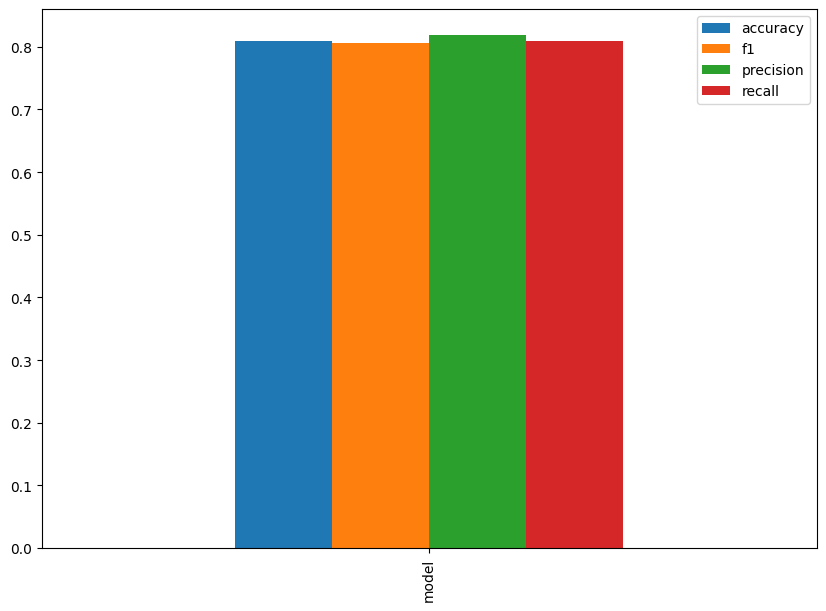

In [20]:
result = pd.DataFrame({
    "model": model_result,
})
result = result.transpose()
result["accuracy"] = result["accuracy"]/100
result.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0,1.0))

## How many did we get wrong

In [21]:
val_df = pd.DataFrame({"text": val_sentences,
                        "target": val_labels,
                        "pred": tf.squeeze(tf.round(model.predict(val_sentences))),
})
val_df

24/24 [==============================] - 1s 22ms/step


,text,target,pred
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0
1,FedEx no longer to transport bioterror germs i...,0,0.0
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0
3,@camilacabello97 Internally and externally scr...,1,0.0
4,Radiation emergency #preparedness starts with ...,1,0.0
...,...,...,...
757,That's the ultimate road to destruction,0,0.0
758,@SetZorah dad why dont you claim me that mean ...,0,0.0
759,FedEx will no longer transport bioterror patho...,0,0.0
760,Crack in the path where I wiped out this morni...,0,0.0


In [23]:
# Find the wrong predictions and sort by predcition probabilites
most_wrong = val_df[val_df["target"] != val_df["pred"]]
most_wrong

,text,target,pred
3,@camilacabello97 Internally and externally scr...,1,0.0
4,Radiation emergency #preparedness starts with ...,1,0.0
11,The Five Fatal Flaws in the Iran Deal https://...,0,1.0
18,Policyholders object to Clico rescue plan http...,1,0.0
19,Brooklyn locksmith: domesticate emergency mech...,0,1.0
...,...,...,...
722,Indeed!! I am fully aware of that battle! I su...,1,0.0
741,#helpme what do I do? My friend has been ticke...,0,1.0
744,Toddler drowned in bath after mum left room to...,1,0.0
745,#ClimateChange Eyewitness to Extreme Weather: ...,1,0.0


In [26]:
print(f"We had {len(val_sentences)} Validation sentences\nWe got {len(most_wrong)} Wrong Predictions\nWe got {len(val_sentences)-len(most_wrong)} Correct Predictions ")

We had 762 Validation sentences
We got 145 Wrong Predictions
We got 617 Correct Predictions 


# Predictions
* We had 762 Validation sentences (100%)
* We got 617 Correct Predictions (81%)
* We got 145 Wrong Predictions (19%)